In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuration
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
print("="*90)
print("BRITISH AIRWAYS LOUNGE ELIGIBILITY ESTIMATOR")
print("="*90)

BRITISH AIRWAYS LOUNGE ELIGIBILITY ESTIMATOR


In [4]:
df = pd.read_excel('British-Airways_Summer_Schedule_Dataset.xlsx')

In [5]:
# Identify key columns
dest_cols = [col for col in df.columns if any(word in col.lower() 
                 for word in ['destination', 'dest', 'to', 'arrival'])]
time_cols = [col for col in df.columns if any(word in col.lower() 
                 for word in ['time', 'departure', 'depart', 'schedule'])]

In [6]:
print(f"\n{'='*90}")
print("STEP 1: CATEGORIZING ROUTES BY REGION AND TYPE")
print(f"{'='*90}")


STEP 1: CATEGORIZING ROUTES BY REGION AND TYPE


In [7]:
regional_mapping = {'Europe': ['AMS', 'CDG', 'FRA', 'MAD', 'BCN', 'FCO', 'MUC', 'ZRH', 'VIE',
                               'CPH', 'ARN', 'OSL', 'HEL', 'DUB', 'BRU', 'LIS', 'ATH', 'PRG',
                               'WAW', 'BUD', 'Amsterdam', 'Paris', 'Frankfurt', 'Madrid',
                               'Barcelona', 'Rome', 'Munich', 'Zurich', 'Vienna', 'Copenhagen',
                               'Stockholm', 'Oslo', 'Helsinki', 'Dublin', 'Brussels', 'Lisbon',
                               'Athens', 'Prague', 'Warsaw', 'Budapest', 'Milan', 'Geneva',
                               'Nice', 'Berlin', 'Hamburg', 'Manchester', 'Edinburgh', 'Glasgow'],
                    'North America': ['JFK', 'LAX', 'ORD', 'DFW', 'YYZ', 'YVR', 'SFO', 'BOS',
                                      'MIA', 'SEA', 'ATL', 'IAD', 'EWR', 'YUL', 'PHX', 'DEN',
                                      'LAS', 'IAH', 'New York', 'Los Angeles', 'Chicago',
                                      'Toronto', 'Vancouver', 'San Francisco', 'Boston',
                                      'Miami', 'Seattle', 'Atlanta', 'Montreal'],
                    'Asia': ['NRT', 'HND', 'ICN', 'PVG', 'PEK', 'HKG', 'SIN', 'BKK', 'DEL',
                             'BOM', 'KUL', 'CGK', 'MNL', 'TPE', 'KIX', 'CAN', 'SHA', 'BLR',
                             'HYD', 'Tokyo', 'Seoul', 'Shanghai', 'Beijing', 'Hong Kong',
                             'Singapore', 'Bangkok', 'Delhi', 'Mumbai', 'Kuala Lumpur',
                             'Jakarta', 'Manila', 'Taipei'],
                    'Middle East': ['DXB', 'DOH', 'AUH', 'KWI', 'RUH', 'JED', 'CAI', 'AMM',
                                    'BEY', 'TLV', 'Dubai', 'Doha', 'Abu Dhabi', 'Kuwait',
                                    'Riyadh', 'Jeddah', 'Cairo', 'Amman', 'Beirut',
                                    'Tel Aviv', 'Muscat', 'Bahrain'],
                    'Africa': ['JNB', 'CPT', 'LOS', 'ACC', 'NBO', 'ADD', 'ALG', 'TUN', 'CMN',
                               'DAR', 'Johannesburg', 'Cape Town', 'Lagos', 'Accra', 'Nairobi',
                               'Addis Ababa'],
                    'South America': ['GRU', 'GIG', 'EZE', 'SCL', 'BOG', 'LIM', 'UIO', 'CCS',
                                      'Sao Paulo', 'Rio de Janeiro', 'Buenos Aires', 'Santiago',
                                      'Bogota', 'Lima'],
                    'Oceania': ['SYD', 'MEL', 'BNE', 'AKL', 'PER', 'ADL', 'Sydney', 'Melbourne',
                                'Brisbane', 'Auckland', 'Perth', 'Adelaide']}

In [8]:
def categorize_destination(dest):
    if pd.isna(dest):
        return 'Unknown'
    dest_str = str(dest).upper()
    for region, patterns in regional_mapping.items():
        if any(pattern.upper() in dest_str for pattern in patterns):
            return region
    return 'Other'

In [9]:
def categorize_route_type(region):
    """Categorize routes by distance/type"""
    if region in ['Europe']:
        return 'Short-Haul'
    elif region in ['North America', 'Middle East', 'Africa']:
        return 'Long-Haul'
    elif region in ['Asia', 'South America', 'Oceania']:
        return 'Ultra Long-Haul'
    else:
        return 'Other'

In [10]:
if dest_cols:
    dest_col = dest_cols[0] # Uses the first destination column found, e.g., 'ARRIVAL_STATION_CD'
    df['Region'] = df[dest_col].apply(categorize_destination)
    df['Route_Type'] = df['Region'].apply(categorize_route_type)
    print(f"✓ Categorized flights by region and route type")
    print("\nRegional Counts:\n", df['Region'].value_counts())
    print("\nRoute Type Counts:\n", df['Route_Type'].value_counts())
else:
    print("Warning: No destination columns found. Cannot categorize by region.")

✓ Categorized flights by region and route type

Regional Counts:
 Region
Europe           5325
North America    2658
Middle East       688
Asia              679
Other             650
Name: count, dtype: int64

Route Type Counts:
 Route_Type
Short-Haul         5325
Long-Haul          3346
Ultra Long-Haul     679
Other               650
Name: count, dtype: int64


In [11]:
print(f"\n{'='*90}")
print("STEP 2: CATEGORIZING FLIGHTS BY TIME OF DAY")
print(f"{'='*90}")


STEP 2: CATEGORIZING FLIGHTS BY TIME OF DAY


In [12]:
def categorize_time(hour):
    if pd.isna(hour):
        return 'Unknown'
    hour = int(hour)
    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [13]:
time_col = time_cols[0] # Uses the first time column found, e.g., 'FLIGHT_TIME'
try:
# Convert to datetime objects, extract the hour
    time_series = pd.to_datetime(df[time_col], format='%H:%M:%S', errors='coerce')
    df['Hour'] = time_series.dt.hour
# Apply the categorization function
    df['Time_Period'] = df['Hour'].apply(categorize_time)
    print(f"✓ Categorized flights into time periods")
    print("\nTime Period Counts:\n", df['Time_Period'].value_counts())
except Exception as e:
    print(f"Error parsing time data: {e}")
    df['Time_Period'] = 'Unknown'

✓ Categorized flights into time periods

Time Period Counts:
 Time_Period
Morning      3530
Afternoon    2910
Evening      2362
Night        1198
Name: count, dtype: int64


In [14]:
print(f"\n{'='*90}")
print("STEP 3: DEFINING LOUNGE ELIGIBILITY ASSUMPTIONS")
print(f"{'='*90}")


STEP 3: DEFINING LOUNGE ELIGIBILITY ASSUMPTIONS


In [15]:
print("""
LOUNGE ACCESS ASSUMPTIONS:

- CONCORDE ROOM (Most Exclusive):
    - First Class passengers (100%)
    - Gold Guest List / Concorde Card holders (rare, ~0.5% of total)
    - Higher on long-haul routes (more premium demand)
    - Peak business hours have more premium travelers

- FIRST LOUNGE:
    - First Class passengers (100%)
    - Business Class passengers on long-haul (eligible)
    - Gold tier Executive Club members (3-5% of passengers)
    - oneworld Emerald members
    - Higher on international routes

- CLUB LOUNGE (Most Common):
    - Business Class passengers (all routes)
    - Club Europe passengers (short-haul)
    - Silver and Gold Executive Club members (8-12% of passengers)
    - oneworld Sapphire and Emerald members
    - Higher percentage on business routes and peak times

ROUTE TYPE ASSUMPTIONS:
    - Short-Haul (Europe): 15-25% premium cabin, lower loyalty tier concentration
    - Long-Haul (Americas, Middle East, Africa): 25-35% premium, higher loyalty
    - Ultra Long-Haul (Asia, Oceania, South America): 30-40% premium, highest loyalty

TIME OF DAY ASSUMPTIONS:
    - Early Morning (00:00-05:59): Lower premium (red-eye leisure)
    - Morning (06:00-11:59): HIGH premium (business departures)
    - Afternoon (12:00-16:59): Medium premium (mixed)
    - Evening (17:00-20:59): HIGH premium (business returns)
    - Night (21:00-23:59): Medium premium (international departures)
""")


LOUNGE ACCESS ASSUMPTIONS:

- CONCORDE ROOM (Most Exclusive):
    - First Class passengers (100%)
    - Gold Guest List / Concorde Card holders (rare, ~0.5% of total)
    - Higher on long-haul routes (more premium demand)
    - Peak business hours have more premium travelers

- FIRST LOUNGE:
    - First Class passengers (100%)
    - Business Class passengers on long-haul (eligible)
    - Gold tier Executive Club members (3-5% of passengers)
    - oneworld Emerald members
    - Higher on international routes

- CLUB LOUNGE (Most Common):
    - Business Class passengers (all routes)
    - Club Europe passengers (short-haul)
    - Silver and Gold Executive Club members (8-12% of passengers)
    - oneworld Sapphire and Emerald members
    - Higher percentage on business routes and peak times

ROUTE TYPE ASSUMPTIONS:
    - Short-Haul (Europe): 15-25% premium cabin, lower loyalty tier concentration
    - Long-Haul (Americas, Middle East, Africa): 25-35% premium, higher loyalty
    - Ultra L

In [16]:
# Define base eligibility rates by route type
base_eligibility = {'Short-Haul': {'concorde_room': 0.02, # 2% - Very few First Class on short-haul
                                   'first_lounge': 0.08, # 8% - Some Business + Gold members
                                   'club_lounge': 0.20}, # 20% - Club Europe + Silver/Gold members
                    'Long-Haul': {'concorde_room': 0.05, # 5% - First Class passengers
                                  'first_lounge': 0.15, # 15% - First + Business + Gold
                                  'club_lounge': 0.30}, # 30% - All premium + loyalty members
                    'Ultra Long-Haul': {'concorde_room': 0.08, # 8% - More First Class on flagship routes
                                        'first_lounge': 0.20, # 20% - Higher premium mix
                                        'club_lounge': 0.35}, # 35% - Highest premium concentration
                    'Other': {'concorde_room': 0.03,
                              'first_lounge': 0.10,
                              'club_lounge': 0.22}}

In [17]:
# Time of day multipliers
time_multipliers = {'Early Morning': 0.75, # 25% reduction - fewer premium travelers
                    'Morning': 1.25, # 25% increase - peak business travel
                    'Afternoon': 1.00, # Baseline
                    'Evening': 1.20, # 20% increase - business returns
                    'Night': 0.95, # 5% reduction - mixed leisure/business
                    'Unknown': 1.00}

In [18]:
# Regional premium multipliers (business vs leisure destinations)
regional_multipliers = {'Europe': 1.00, # Baseline - mix of business and leisure
                        'North America': 1.15, # 15% higher - strong business travel
                        'Asia': 1.10, # 10% higher - business hubs
                        'Middle East': 1.05, # 5% higher - premium connections
                        'Africa': 0.95, # 5% lower - more leisure
                        'South America': 0.90, # 10% lower - more leisure
                        'Oceania': 0.95, # 5% lower - more leisure
                        'Other': 1.00,
                        'Unknown': 1.00}
print("✓ Assumption dictionaries defined.")

✓ Assumption dictionaries defined.


In [19]:
print(f"\n{'='*90}")
print("STEP 4: CALCULATING LOUNGE ELIGIBILITY PERCENTAGES")
print(f"{'='*90}")


STEP 4: CALCULATING LOUNGE ELIGIBILITY PERCENTAGES


In [20]:
def calculate_eligibility(row):
    """Calculate lounge eligibility for each flight"""
    route_type = row.get('Route_Type', 'Other')
    time_period = row.get('Time_Period', 'Unknown')
    region = row.get('Region', 'Unknown')

# Get base rates
    base = base_eligibility.get(route_type, base_eligibility['Other'])
# Get multipliers
    time_mult = time_multipliers.get(time_period, 1.0)
    region_mult = regional_multipliers.get(region, 1.0)
# Calculate final percentages
    concorde = min(base['concorde_room'] * time_mult * region_mult, 0.15) # Cap at 15%
    first = min(base['first_lounge'] * time_mult * region_mult, 0.35) # Cap at 35%
    club = min(base['club_lounge'] * time_mult * region_mult, 0.50) # Cap at 50%

    return pd.Series({'Concorde_Room_Pct': round(concorde * 100, 2),
                      'First_Lounge_Pct': round(first * 100, 2),
                      'Club_Lounge_Pct': round(club * 100, 2)})

In [21]:
# Apply calculations to every row
eligibility_df = df.apply(calculate_eligibility, axis=1)
df = pd.concat([df, eligibility_df], axis=1)
print("✓ Calculated eligibility percentages for all flights")
print("\nDataFrame head with new percentage columns:")
print(df[['FLIGHT_NO', 'Region', 'Route_Type', 'Time_Period', 'Concorde_Room_Pct',
          'First_Lounge_Pct', 'Club_Lounge_Pct']].head())

✓ Calculated eligibility percentages for all flights

DataFrame head with new percentage columns:
  FLIGHT_NO         Region  Route_Type Time_Period  Concorde_Room_Pct  \
0    BA5211  North America   Long-Haul   Afternoon               5.75   
1    BA7282  North America   Long-Haul     Morning               7.19   
2    BA1896         Europe  Short-Haul   Afternoon               2.00   
3    BA5497          Other       Other     Evening               3.60   
4    BA1493         Europe  Short-Haul     Evening               2.40   

   First_Lounge_Pct  Club_Lounge_Pct  
0             17.25            34.50  
1             21.56            43.12  
2              8.00            20.00  
3             12.00            26.40  
4              9.60            24.00  


In [22]:
print(f"\n{'='*90}")
print("STEP 5: GENERATING SUMMARY TABLES (Part 1)")
print(f"{'='*90}")


STEP 5: GENERATING SUMMARY TABLES (Part 1)


In [23]:
# Summary by Route Type
print("\n📊 AVERAGE LOUNGE ELIGIBILITY BY ROUTE TYPE")
print("="*90)
route_summary = df.groupby('Route_Type')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].agg(['mean', 'min', 'max'])
print(route_summary.round(2))


📊 AVERAGE LOUNGE ELIGIBILITY BY ROUTE TYPE
                Concorde_Room_Pct              First_Lounge_Pct                \
                             mean   min    max             mean    min    max   
Route_Type                                                                      
Long-Haul                    6.39  4.99   7.19            19.16  14.96  21.56   
Other                        3.39  2.85   3.75            11.30   9.50  12.50   
Short-Haul                   2.26  1.90   2.50             9.03   7.60  10.00   
Ultra Long-Haul              9.91  8.36  11.00            24.78  20.90  27.50   

                Club_Lounge_Pct                
                           mean    min    max  
Route_Type                                     
Long-Haul                 38.33  29.92  43.12  
Other                     24.87  20.90  27.50  
Short-Haul                22.57  19.00  25.00  
Ultra Long-Haul           43.37  36.57  48.13  


In [24]:
# Summary by Time Period
print(f"\n{'='*99}")
print("📊 AVERAGE LOUNGE ELIGIBILITY BY TIME OF DAY")
print("="*90)
time_summary = df.groupby('Time_Period')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].agg(['mean', 'min', 'max'])
print(time_summary.round(2))


📊 AVERAGE LOUNGE ELIGIBILITY BY TIME OF DAY
            Concorde_Room_Pct             First_Lounge_Pct              \
                         mean  min    max             mean   min   max   
Time_Period                                                              
Afternoon                3.74  2.0   8.80            12.04   8.0  22.0   
Evening                  4.42  2.4  10.56            14.31   9.6  26.4   
Morning                  4.74  2.5  11.00            15.22  10.0  27.5   
Night                    3.58  1.9   8.36            11.52   7.6  20.9   

            Club_Lounge_Pct               
                       mean   min    max  
Time_Period                               
Afternoon             25.98  20.0  38.50  
Evening               30.97  24.0  46.20  
Morning               32.74  25.0  48.13  
Night                 24.81  19.0  36.57  


In [25]:
# Summary by Region
print(f"\n{'='*90}")
print("📊 AVERAGE LOUNGE ELIGIBILITY BY DESTINATION REGION")
print("="*90)
region_summary = df.groupby('Region')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].mean()
print(region_summary.round(2))


📊 AVERAGE LOUNGE ELIGIBILITY BY DESTINATION REGION
               Concorde_Room_Pct  First_Lounge_Pct  Club_Lounge_Pct
Region                                                             
Asia                        9.91             24.78            43.37
Europe                      2.26              9.03            22.57
Middle East                 5.96             17.89            35.78
North America               6.50             19.49            38.98
Other                       3.39             11.30            24.87


In [26]:
print(f"\n{'='*90}")
print("STEP 5: GENERATING SUMMARY TABLES (Part 2 - Pivot Tables)")
print(f"{'='*90}")


STEP 5: GENERATING SUMMARY TABLES (Part 2 - Pivot Tables)


In [27]:
# Cross-tabulation: Route Type × Time Period
print("\n📊 CONCORDE ROOM ELIGIBILITY: Route Type × Time Period")
print("="*90)


📊 CONCORDE ROOM ELIGIBILITY: Route Type × Time Period


In [28]:
concorde_pivot = df.pivot_table(values='Concorde_Room_Pct', index='Route_Type',
                                columns='Time_Period', aggfunc='mean')
print(concorde_pivot.round(2))

Time_Period      Afternoon  Evening  Morning  Night
Route_Type                                         
Long-Haul             5.65     6.77     7.06   5.38
Other                 3.00     3.60     3.75   2.85
Short-Haul            2.00     2.40     2.50   1.90
Ultra Long-Haul       8.80    10.56    11.00   8.36


In [29]:
print(f"\n{'='*90}")
print("📊 FIRST LOUNGE ELIGIBILITY: Route Type × Time Period")
print("="*90)


📊 FIRST LOUNGE ELIGIBILITY: Route Type × Time Period


In [30]:
first_pivot = df.pivot_table(values='First_Lounge_Pct', 
                             index='Route_Type', 
                             columns='Time_Period', 
                             aggfunc='mean')
print(first_pivot.round(2))

Time_Period      Afternoon  Evening  Morning  Night
Route_Type                                         
Long-Haul            16.94     20.3    21.18  16.14
Other                10.00     12.0    12.50   9.50
Short-Haul            8.00      9.6    10.00   7.60
Ultra Long-Haul      22.00     26.4    27.50  20.90


In [31]:
print(f"\n{'='*90}")
print("📊 CLUB LOUNGE ELIGIBILITY: Route Type × Time Period")
print("="*90)


📊 CLUB LOUNGE ELIGIBILITY: Route Type × Time Period


In [32]:
club_pivot = df.pivot_table(values='Club_Lounge_Pct', 
                            index='Route_Type', 
                            columns='Time_Period', 
                            aggfunc='mean')
print(club_pivot.round(2))

Time_Period      Afternoon  Evening  Morning  Night
Route_Type                                         
Long-Haul            33.89    40.59    42.35  32.27
Other                22.00    26.40    27.50  20.90
Short-Haul           20.00    24.00    25.00  19.00
Ultra Long-Haul      38.50    46.20    48.13  36.57


In [33]:
# Save summary tables
concorde_pivot.to_csv('ba_concorde_room_summary.csv')
first_pivot.to_csv('ba_first_lounge_summary.csv')
club_pivot.to_csv('ba_club_lounge_summary.csv')
print("\n✓ Saved summary tables for each lounge type")


✓ Saved summary tables for each lounge type


In [34]:
print(f"\n{'='*90}")
print("STEP 5: GENERATING SUMMARY TABLES (Part 3 - Detailed Breakdown)")
print(f"{'='*90}")


STEP 5: GENERATING SUMMARY TABLES (Part 3 - Detailed Breakdown)


In [35]:
detailed_summary = df.groupby(['Route_Type', 'Time_Period', 'Region'])[['Concorde_Room_Pct',
                                                                        'First_Lounge_Pct',
                                                                        'Club_Lounge_Pct']].agg(['mean', 'count'])

In [36]:
# Clean up multi-index columns
detailed_summary.columns = ['_'.join(col).strip() for col in detailed_summary.columns.values]
detailed_summary = detailed_summary.round(2)
print("📊 COMPREHENSIVE SUMMARY (Top 30 rows):")
print(detailed_summary.head(30))

📊 COMPREHENSIVE SUMMARY (Top 30 rows):
                                           Concorde_Room_Pct_mean  \
Route_Type      Time_Period Region                                  
Long-Haul       Afternoon   Middle East                      5.25   
                            North America                    5.75   
                Evening     Middle East                      6.30   
                            North America                    6.90   
                Morning     Middle East                      6.56   
                            North America                    7.19   
                Night       Middle East                      4.99   
                            North America                    5.46   
Other           Afternoon   Other                            3.00   
                Evening     Other                            3.60   
                Morning     Other                            3.75   
                Night       Other                            2.8

In [37]:
# Save detailed results
output_file = 'ba_lounge_eligibility_detailed.csv'
result_df = df[['Region', 'Route_Type', 'Time_Period', 
                'Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].copy()
result_df.to_csv(output_file, index=False)
print(f"\n✓ Saved detailed results to: {output_file}")


✓ Saved detailed results to: ba_lounge_eligibility_detailed.csv


In [38]:
print(f"\n{'='*90}")
print("STEP 6: CREATING VISUALIZATIONS (Heatmaps)")
print(f"{'='*90}")


STEP 6: CREATING VISUALIZATIONS (Heatmaps)



✓ Saved heatmaps: ba_lounge_eligibility_heatmaps.png


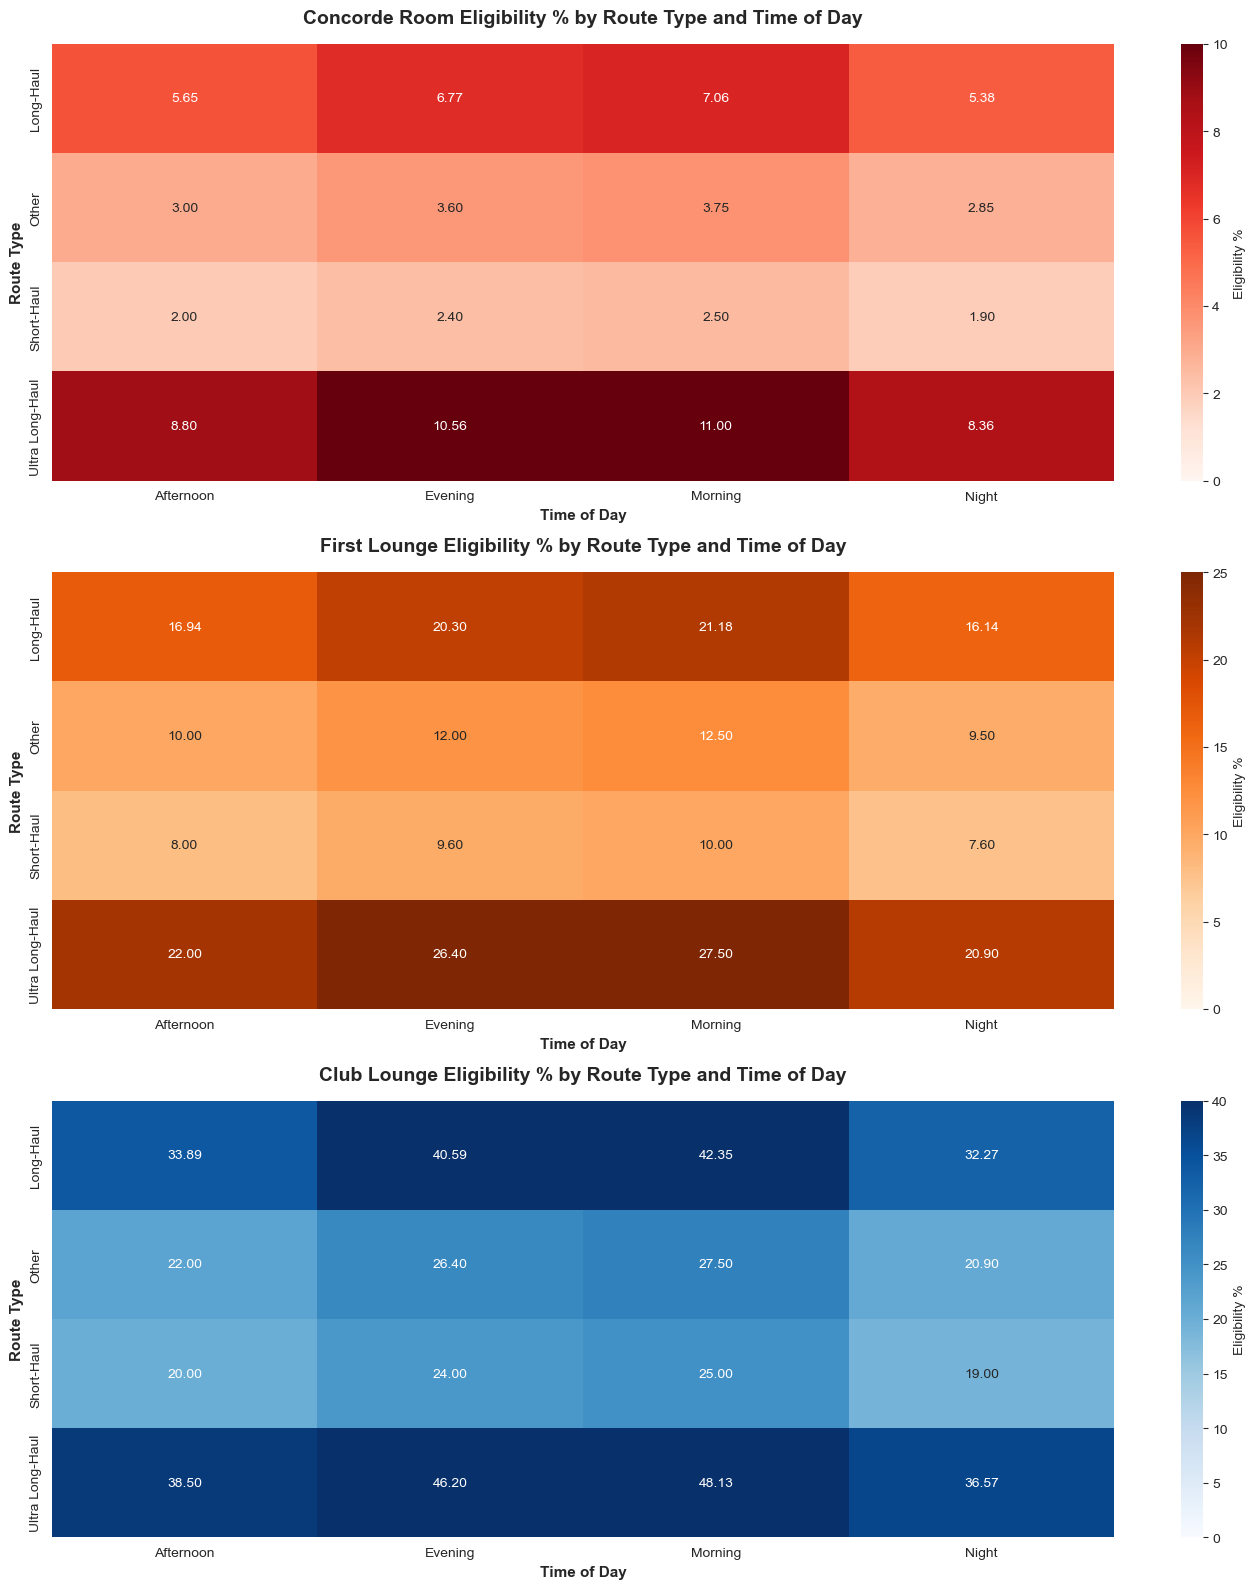

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
# Concorde Room
sns.heatmap(concorde_pivot, annot=True, fmt='.2f', cmap='Reds', 
            cbar_kws={'label': 'Eligibility %'}, ax=axes[0], vmin=0, vmax=10)
axes[0].set_title('Concorde Room Eligibility % by Route Type and Time of Day', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Time of Day', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Route Type', fontsize=11, fontweight='bold')

# First Lounge
sns.heatmap(first_pivot, annot=True, fmt='.2f', cmap='Oranges', 
            cbar_kws={'label': 'Eligibility %'}, ax=axes[1], vmin=0, vmax=25)
axes[1].set_title('First Lounge Eligibility % by Route Type and Time of Day', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Time of Day', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Route Type', fontsize=11, fontweight='bold')

# Club Lounge
sns.heatmap(club_pivot, annot=True, fmt='.2f', cmap='Blues', 
            cbar_kws={'label': 'Eligibility %'}, ax=axes[2], vmin=0, vmax=40)
axes[2].set_title('Club Lounge Eligibility % by Route Type and Time of Day', 
                  fontsize=14, fontweight='bold', pad=15)
axes[2].set_xlabel('Time of Day', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Route Type', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('ba_lounge_eligibility_heatmaps.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved heatmaps: ba_lounge_eligibility_heatmaps.png")
plt.show()
plt.close()

In [40]:
print(f"\n{'='*90}")
print("STEP 6: CREATING VISUALIZATIONS (Bar Chart by Route Type)")
print(f"{'='*90}")


STEP 6: CREATING VISUALIZATIONS (Bar Chart by Route Type)


✓ Saved bar chart: ba_lounge_by_route_type.png


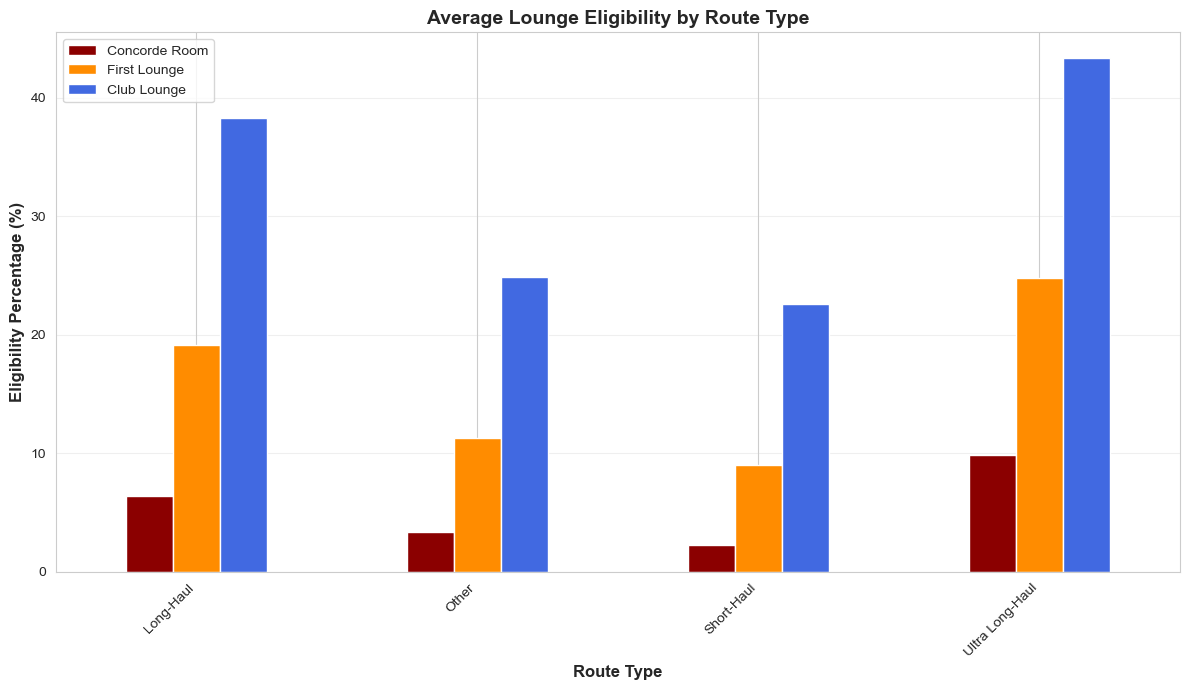

In [41]:
fig, ax = plt.subplots(figsize=(12, 7))
route_avg = df.groupby('Route_Type')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].mean()
route_avg.plot(kind='bar', ax=ax, color=['#8B0000', '#FF8C00', '#4169E1'])

ax.set_title('Average Lounge Eligibility by Route Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Route Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Eligibility Percentage (%)', fontsize=12, fontweight='bold')
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('ba_lounge_by_route_type.png', dpi=300, bbox_inches='tight')
print("✓ Saved bar chart: ba_lounge_by_route_type.png")
plt.show()
plt.close()

In [42]:
print(f"\n{'='*90}")
print("STEP 6: CREATING VISUALIZATIONS (Bar Chart by Time of Day)")
print(f"{'='*90}")


STEP 6: CREATING VISUALIZATIONS (Bar Chart by Time of Day)


✓ Saved bar chart: ba_lounge_by_time.png


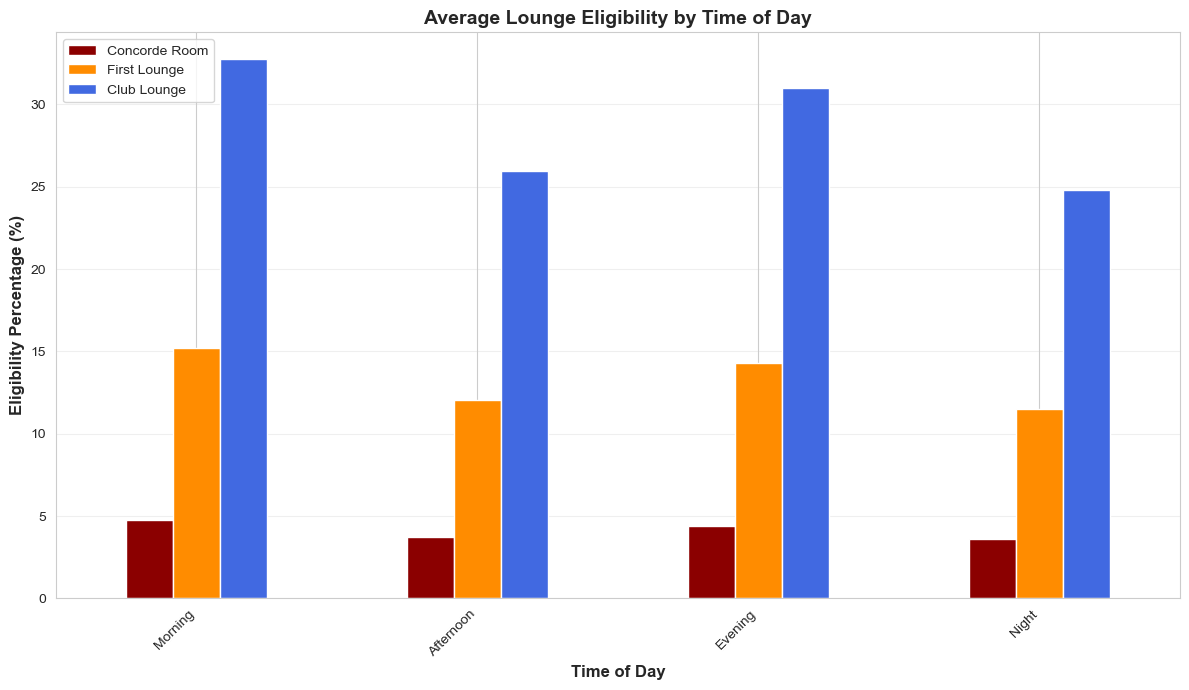

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))
time_avg = df.groupby('Time_Period')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].mean()
# Ensure a logical order for the x-axis
time_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Unknown']
time_avg = time_avg.reindex([t for t in time_order if t in time_avg.index])

time_avg.plot(kind='bar', ax=ax, color=['#8B0000', '#FF8C00', '#4169E1'])
ax.set_title('Average Lounge Eligibility by Time of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Time of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Eligibility Percentage (%)', fontsize=12, fontweight='bold')
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
    
plt.savefig('ba_lounge_by_time.png', dpi=300, bbox_inches='tight')
print("✓ Saved bar chart: ba_lounge_by_time.png")
plt.show()
plt.close()

In [44]:
print(f"\n{'='*90}")
print("STEP 6: CREATING VISUALIZATIONS (Bar Chart by Region)")
print(f"{'='*90}")


STEP 6: CREATING VISUALIZATIONS (Bar Chart by Region)


✓ Saved bar chart: ba_lounge_by_region.png


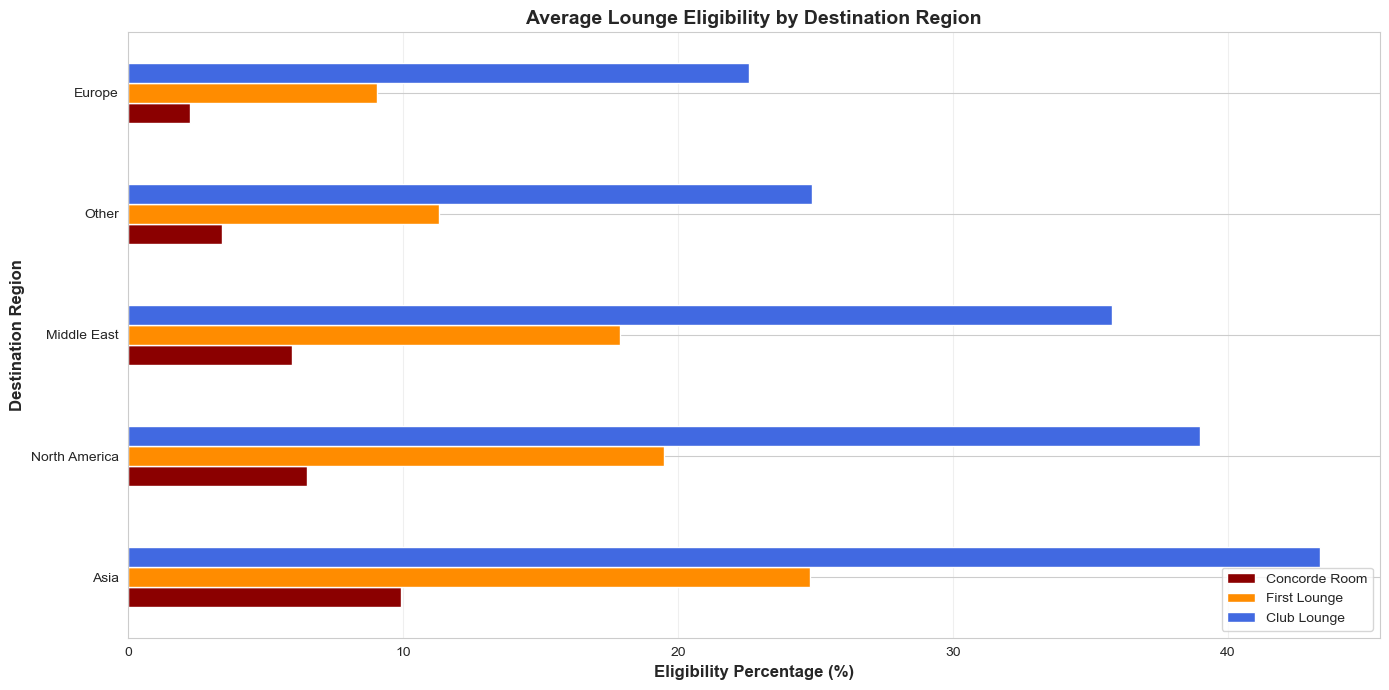

In [45]:
fig, ax = plt.subplots(figsize=(14, 7))
region_avg = df.groupby('Region')[['Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']].mean()
region_avg = region_avg.sort_values('Club_Lounge_Pct', ascending=False)
    
region_avg.plot(kind='barh', ax=ax, color=['#8B0000', '#FF8C00', '#4169E1'])
ax.set_title('Average Lounge Eligibility by Destination Region', fontsize=14, fontweight='bold')
ax.set_xlabel('Eligibility Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Destination Region', fontsize=12, fontweight='bold')
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
    
plt.savefig('ba_lounge_by_region.png', dpi=300, bbox_inches='tight')
print("✓ Saved bar chart: ba_lounge_by_region.png")
plt.show()
plt.close()

In [46]:
print(f"\n{'='*90}")
print("STEP 7: KEY INSIGHTS AND STATISTICS")
print(f"{'='*90}")


STEP 7: KEY INSIGHTS AND STATISTICS


In [47]:
print("\n CONCORDE ROOM ACCESS:")
print(f"   Overall Average: {df['Concorde_Room_Pct'].mean():.2f}%")
print(f"   Highest: {df['Concorde_Room_Pct'].max():.2f}% (e.g., Ultra Long-Haul, Morning/Evening)")
print(f"   Lowest: {df['Concorde_Room_Pct'].min():.2f}% (e.g., Short-Haul, Early Morning)")

print("\n FIRST LOUNGE ACCESS:")
print(f"   Overall Average: {df['First_Lounge_Pct'].mean():.2f}%")
print(f"   Highest: {df['First_Lounge_Pct'].max():.2f}%")
print(f"   Lowest: {df['First_Lounge_Pct'].min():.2f}%")

print("\n CLUB LOUNGE ACCESS:")
print(f"   Overall Average: {df['Club_Lounge_Pct'].mean():.2f}%")
print(f"   Highest: {df['Club_Lounge_Pct'].max():.2f}%")
print(f"   Lowest: {df['Club_Lounge_Pct'].min():.2f}%")


 CONCORDE ROOM ACCESS:
   Overall Average: 4.23%
   Highest: 11.00% (e.g., Ultra Long-Haul, Morning/Evening)
   Lowest: 1.90% (e.g., Short-Haul, Early Morning)

 FIRST LOUNGE ACCESS:
   Overall Average: 13.64%
   Highest: 27.50%
   Lowest: 7.60%

 CLUB LOUNGE ACCESS:
   Overall Average: 29.41%
   Highest: 48.13%
   Lowest: 19.00%


In [48]:
# Estimated passenger counts
total_flights = len(df)
avg_passengers_per_flight = 180  # Typical average assumption

In [49]:
print(f"\n ESTIMATED TOTAL LOUNGE USAGE (assuming {avg_passengers_per_flight} pax/flight):")
total_pax = total_flights * avg_passengers_per_flight
concorde_pax = total_pax * (df['Concorde_Room_Pct'].mean() / 100)
first_pax = total_pax * (df['First_Lounge_Pct'].mean() / 100)
club_pax = total_pax * (df['Club_Lounge_Pct'].mean() / 100)
print(f"   Total Passengers: {total_pax:,.0f}")
print(f"   Concorde Room: {concorde_pax:,.0f} passengers ({df['Concorde_Room_Pct'].mean():.2f}%)")
print(f"   First Lounge: {first_pax:,.0f} passengers ({df['First_Lounge_Pct'].mean():.2f}%)")
print(f"   Club Lounge: {club_pax:,.0f} passengers ({df['Club_Lounge_Pct'].mean():.2f}%)")


 ESTIMATED TOTAL LOUNGE USAGE (assuming 180 pax/flight):
   Total Passengers: 1,800,000
   Concorde Room: 76,194 passengers (4.23%)
   First Lounge: 245,475 passengers (13.64%)
   Club Lounge: 529,295 passengers (29.41%)


In [50]:
print(f"\n{'='*99}")
print("ANALYSIS COMPLETE!")
print(f"{'='*90}")


ANALYSIS COMPLETE!


In [51]:
print(f"{'='*90}")
print("\nGenerated files:")
print("  📄 ba_lounge_eligibility_detailed.csv - Full dataset with eligibility %")
print("  📄 ba_concorde_room_summary.csv - Concorde Room by route/time")
print("  📄 ba_first_lounge_summary.csv - First Lounge by route/time")
print("  📄 ba_club_lounge_summary.csv - Club Lounge by route/time")
print("  📊 ba_lounge_eligibility_heatmaps.png - All three lounge heatmaps")
print("  📊 ba_lounge_by_route_type.png - Comparison by route type")
print("  📊 ba_lounge_by_time.png - Comparison by time of day")
print("  📊 ba_lounge_by_region.png - Comparison by region")
print(f"{'='*90}")


Generated files:
  📄 ba_lounge_eligibility_detailed.csv - Full dataset with eligibility %
  📄 ba_concorde_room_summary.csv - Concorde Room by route/time
  📄 ba_first_lounge_summary.csv - First Lounge by route/time
  📄 ba_club_lounge_summary.csv - Club Lounge by route/time
  📊 ba_lounge_eligibility_heatmaps.png - All three lounge heatmaps
  📊 ba_lounge_by_route_type.png - Comparison by route type
  📊 ba_lounge_by_time.png - Comparison by time of day
  📊 ba_lounge_by_region.png - Comparison by region
